# CS436 Computer Vision Project - Week 1 Deliverable


**Student:** Muhammad Zain Naseer , Kousar Pervaiz



In [37]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from itertools import product
from PIL import Image
from PIL.ExifTags import TAGS



plt.rcParams['figure.figsize'] = (12, 10)


## 1. Load Image Dataset



In [38]:

IMAGE_DIR = r"images"  


image_paths = sorted(glob.glob(f"{IMAGE_DIR}/*.jpg"))

print(f"{len(image_paths)} images")

26 images


In [39]:

images = []
for path in image_paths:
    img = cv2.imread(path)
    if img is not None:
        images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
    else:
        print(f"Warning: Could not load {path}")

print(f"Loaded {len(images)} images successfully")
if len(images) > 0:
    print(f"Image shape: {images[0].shape}")

Loaded 26 images successfully
Image shape: (8160, 6120, 3)


## 2. Display Image Grid (10 Images)

Displaying a grid of 10 images from the dataset to show the variety of viewpoints.

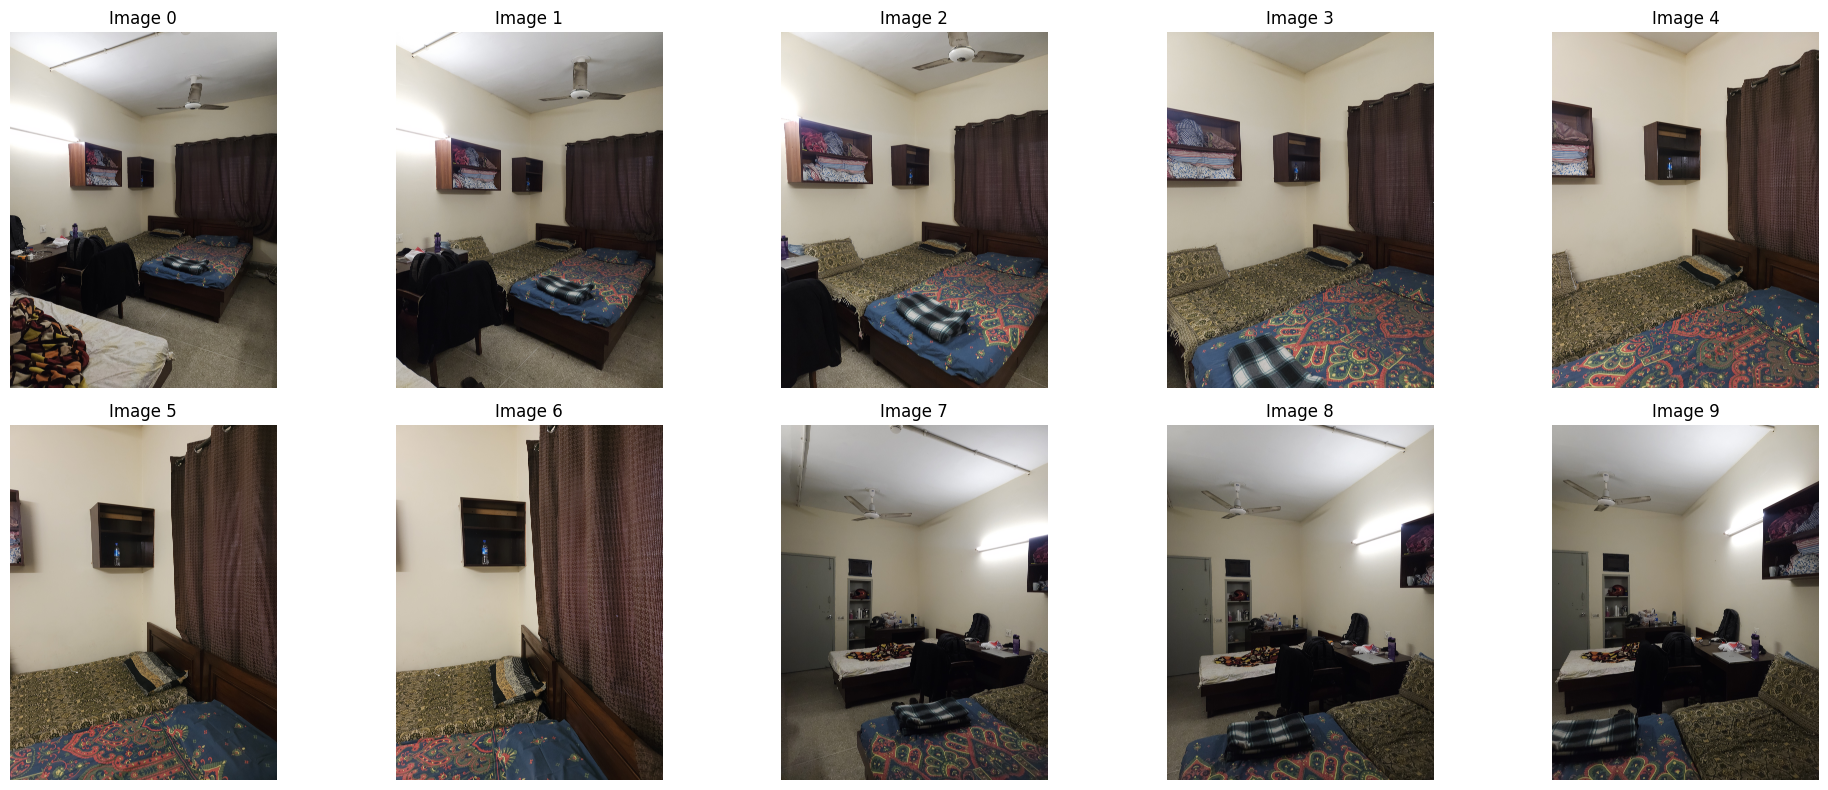

In [40]:
def display_image_grid(images, n_images, cols):

    n_images = min(n_images, len(images))
    rows = (n_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
    axes = axes.flatten() if n_images > 1 else [axes]
    
    for i in range(n_images):
        axes[i].imshow(images[i])
        axes[i].set_title(f'Image {i}', fontsize=12)
        axes[i].axis('off')
    

    for i in range(n_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

display_image_grid(images, n_images=10, cols=5)

## 3. Image Preprocessing



In [41]:
def preprocess_image(img, target_width=1920, convert_to_gray=True):

    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    

    h, w = img_bgr.shape[:2]
    if w > target_width:
        scale = target_width / w
        new_w = int(w * scale)
        new_h = int(h * scale)
        img_bgr = cv2.resize(img_bgr, (new_w, new_h), interpolation=cv2.INTER_AREA)
    

    

    if convert_to_gray:
        return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    else:
     
        return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)


if len(images) > 0:
    sample_img = images[0]
    print(f"Original image shape: {sample_img.shape}")
    

    preprocessed_images = []
    for img in images:
        preprocessed = preprocess_image(img, convert_to_gray=True)
        preprocessed_images.append(preprocessed)
    
    print(f"Preprocessed {len(preprocessed_images)} images")
    print(f"Preprocessed image shape: {preprocessed_images[0].shape}")
    print(f"Image is now grayscale: {len(preprocessed_images[0].shape) == 2}")
else:
    preprocessed_images = images
    print("No preprocessing applied (using original images)")

Original image shape: (8160, 6120, 3)
Preprocessed 26 images
Preprocessed image shape: (2560, 1920)
Image is now grayscale: True


## 4. Feature Detection and Matching

Using SIFT (Scale-Invariant Feature Transform) to detect and match features between consecutive images.

### 4.1 Feature Detection Setup

In [42]:

sift = cv2.SIFT_create(nfeatures=10000)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

print("Feature detector and matcher initialized")

Feature detector and matcher initialized


### 4.2 Detect Features in All Images

In [43]:

keypoints_list = []
descriptors_list = []
images_color = []  

for i, img in enumerate(preprocessed_images):
    kp, desc = sift.detectAndCompute(img, None)
    keypoints_list.append(kp)
    descriptors_list.append(desc)
    
    
    img_color = preprocess_image(images[i], convert_to_gray=False)
    images_color.append(img_color)

print(f"\nTotal images processed: {len(keypoints_list)}")
print(f"Color images stored: {len(images_color)}")


Total images processed: 26
Color images stored: 26


### 4.3 Visualize Keypoints on Sample Image

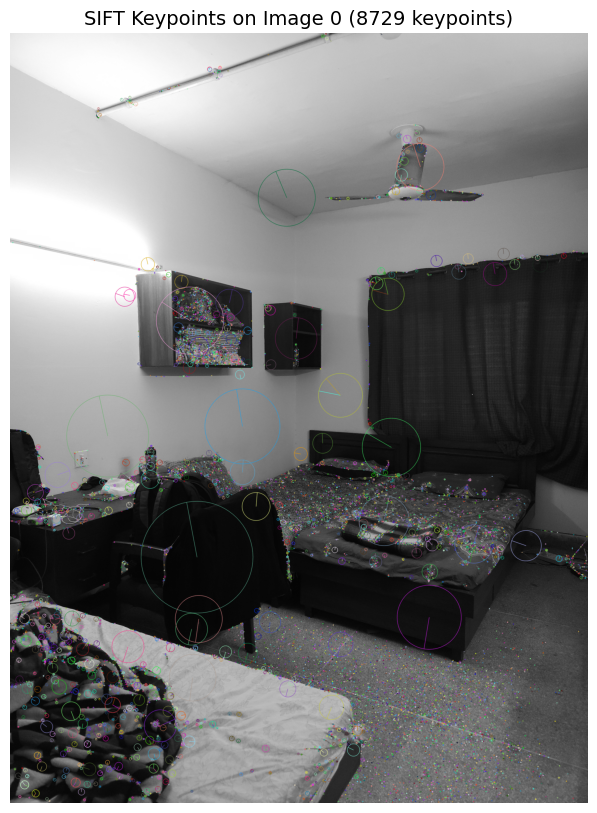

In [44]:

img_with_kp = cv2.drawKeypoints(
    cv2.cvtColor(preprocessed_images[0], cv2.COLOR_RGB2BGR),
    keypoints_list[0],
    None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))
plt.title(f'SIFT Keypoints on Image 0 ({len(keypoints_list[0])} keypoints)', fontsize=14)
plt.axis('off')
plt.show()

## 5. Feature Matching Between Consecutive Images

Matching features between 4-5 consecutive image pairs using Lowe's ratio test.

In [45]:
def match_features(desc1, desc2, ratio_thresh=0.7):

    matches = flann.knnMatch(desc1, desc2, k=2)
    
    
    good_matches = []
    for match_pair in matches:
        if len(match_pair) == 2:
            m, n = match_pair
            if m.distance < ratio_thresh * n.distance:
                good_matches.append(m)
    
    return good_matches

def visualize_matches(img1, kp1, img2, kp2, matches, title=""):
    
    
    img1_bgr = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
    img2_bgr = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)
    
    
    img_matches = cv2.drawMatches(
        img1_bgr, kp1, img2_bgr, kp2, matches[:50], None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title(title, fontsize=14)
    plt.axis('off')
    return img_matches

### 5.1 Match Features Between 4-5 Consecutive Image Pairs

Matching features between 5 consecutive image pairs


--- Matching Image 0 and Image 1 ---
Found 1202 good matches


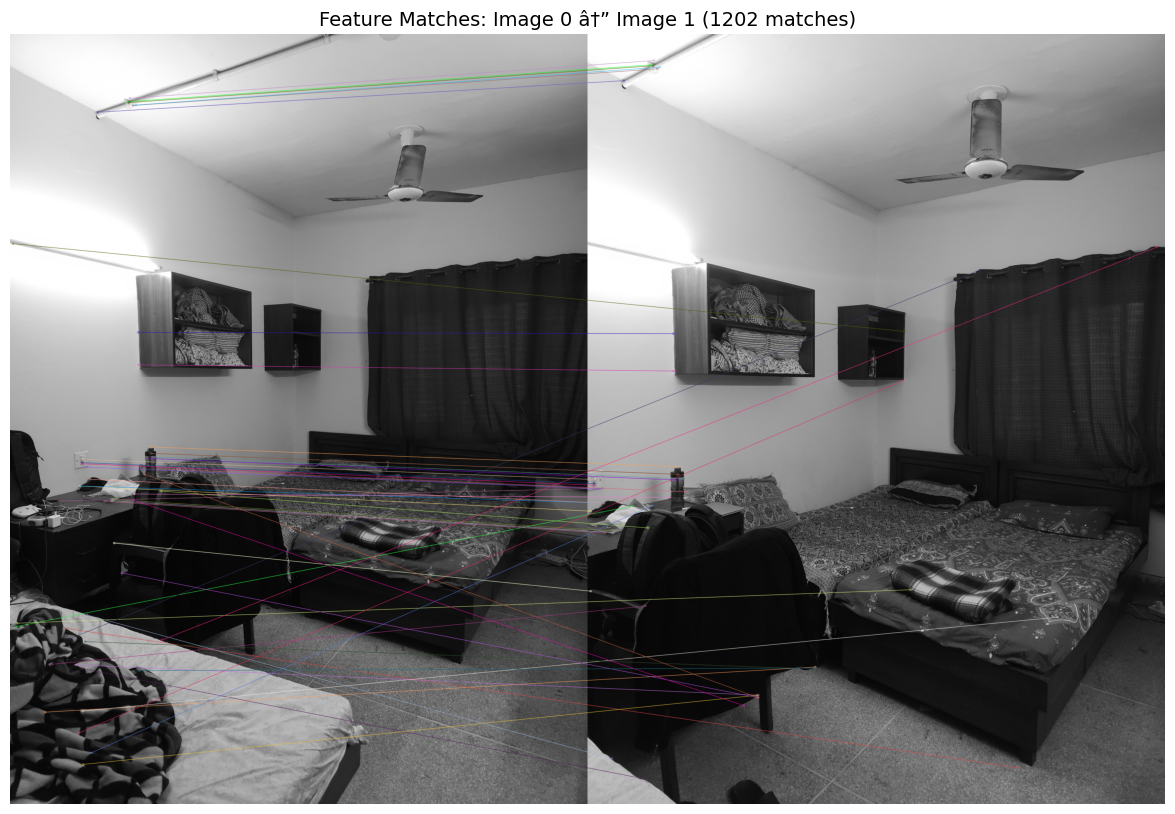


--- Matching Image 1 and Image 2 ---
Found 1106 good matches


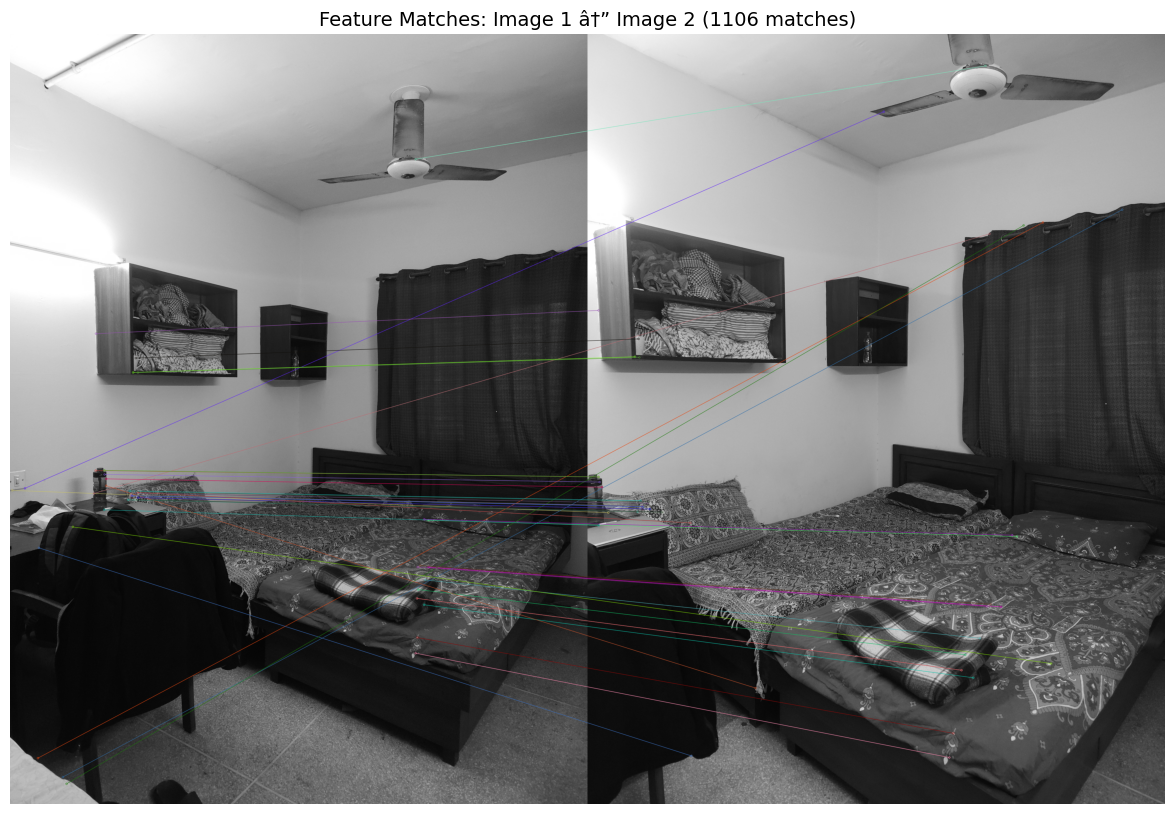


--- Matching Image 2 and Image 3 ---
Found 835 good matches


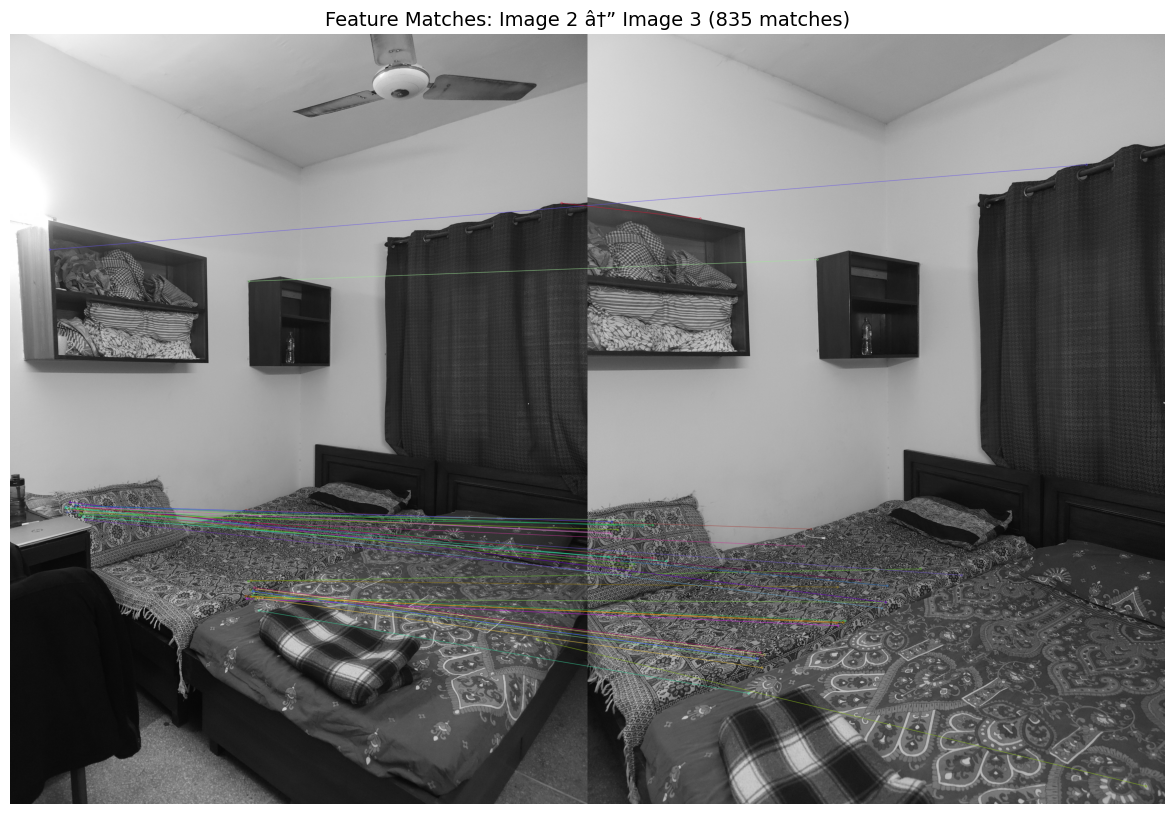


--- Matching Image 3 and Image 4 ---
Found 976 good matches


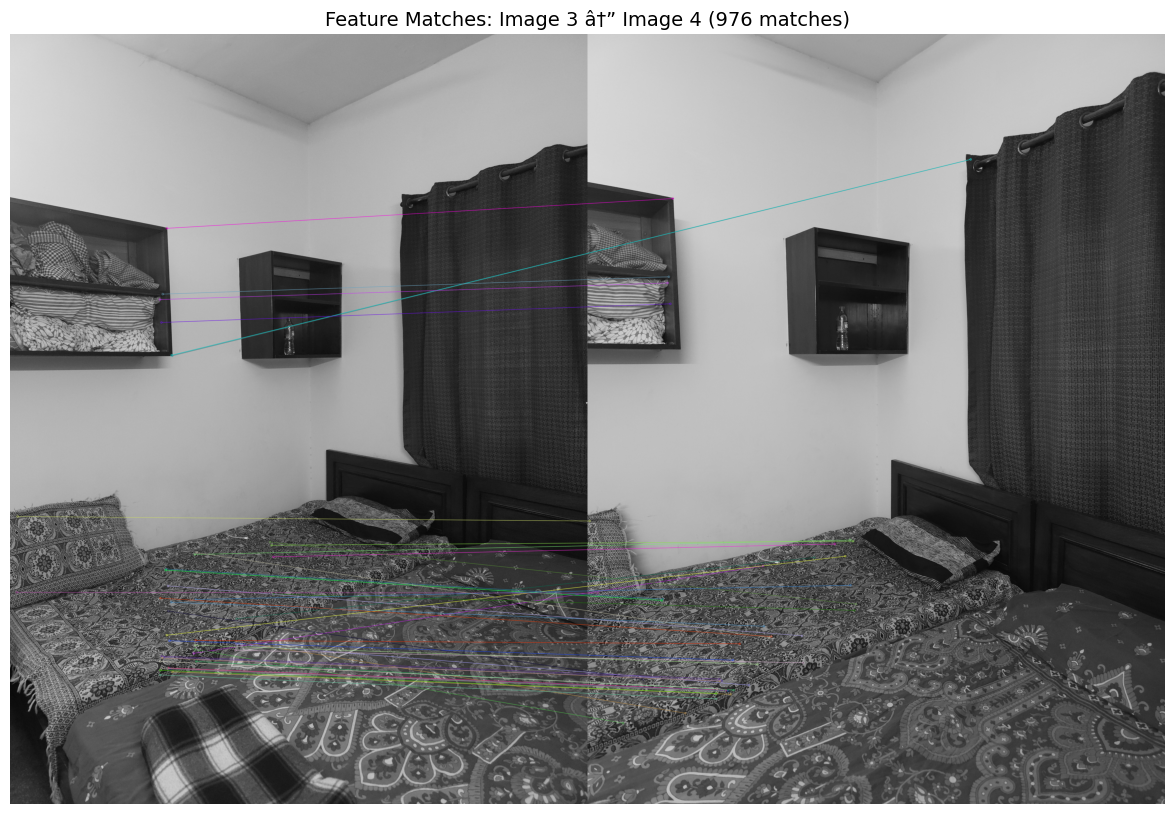


--- Matching Image 4 and Image 5 ---
Found 1070 good matches


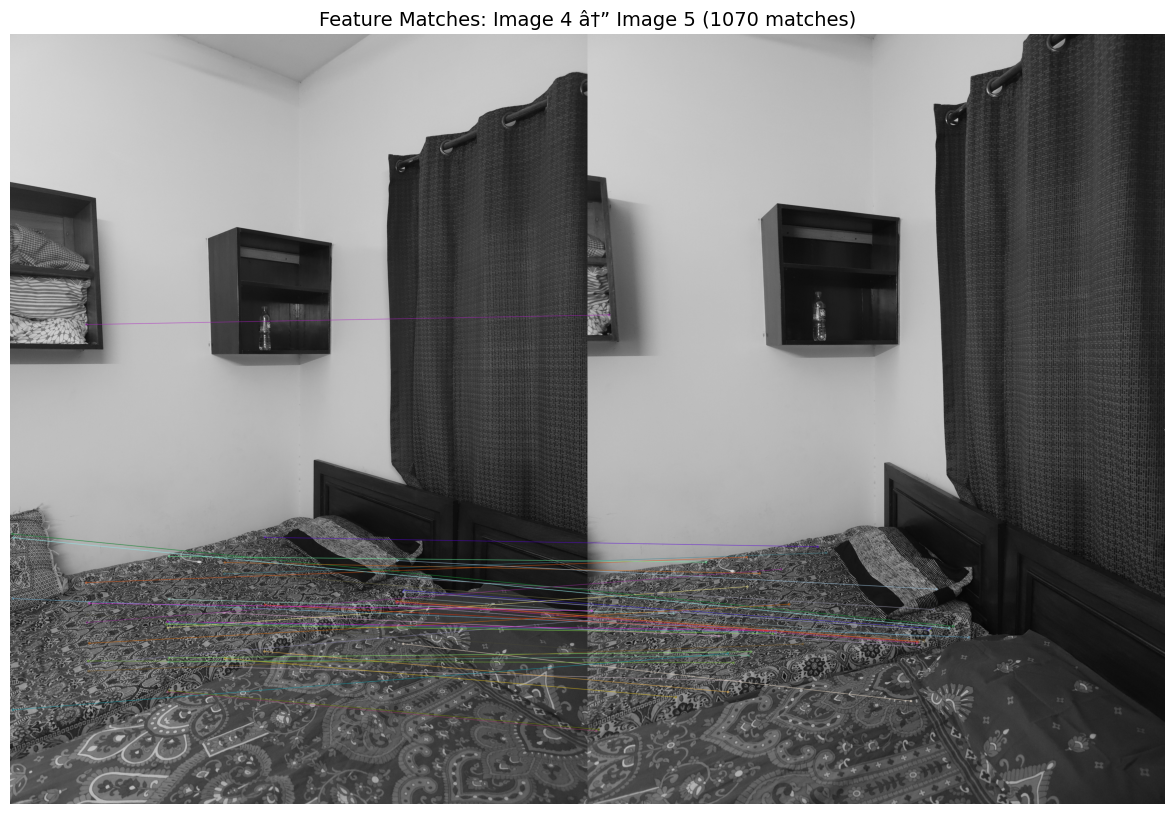

In [46]:

n_pairs = min(5, len(preprocessed_images) - 1)

print(f"Matching features between {n_pairs} consecutive image pairs\n")

for i in range(n_pairs):
    print(f"\n--- Matching Image {i} and Image {i+1} ---")
    
    
    matches = match_features(descriptors_list[i], descriptors_list[i+1])
    
    print(f"Found {len(matches)} good matches")
    
    
    title = f'Feature Matches: Image {i} â†” Image {i+1} ({len(matches)} matches)'
    visualize_matches(
        preprocessed_images[i], keypoints_list[i],
        preprocessed_images[i+1], keypoints_list[i+1],
        matches, title
    )
    
    

    plt.show()

---

# Week 2: Two-View Reconstruction



In [47]:


img1_gray = preprocessed_images[0]
img2_gray = preprocessed_images[1]
img1_color = images_color[0]
img2_color = images_color[1]

kp1 = keypoints_list[0]
kp2 = keypoints_list[1]
desc1 = descriptors_list[0]
desc2 = descriptors_list[1]

print(f"\nUsing Image 0 and Image 1 for reconstruction")
print(f"Image 1: {len(kp1)} keypoints")
print(f"Image 2: {len(kp2)} keypoints")


matches = match_features(desc1, desc2, ratio_thresh=0.75)
print(f"Found {len(matches)} matches")


Using Image 0 and Image 1 for reconstruction
Image 1: 8729 keypoints
Image 2: 10000 keypoints
Found 1388 matches


In [48]:

def get_camera_intrinsics_from_exif(image_path, img_shape):

    img = Image.open(image_path)
    exif = img._getexif()
    
    if exif is None:
        print("No EXIF data found, using estimation")
        return estimate_camera_intrinsics(img_shape)
    
    
    exif_data = {}
    for tag_id, value in exif.items():
        tag = TAGS.get(tag_id, tag_id)
        exif_data[tag] = value
    
    
    focal_length_mm = float(exif_data.get('FocalLength', 0))
    focal_length_35mm = exif_data.get('FocalLengthIn35mmFilm', 0)
    
    
    orig_width = exif_data.get('ExifImageWidth', img_shape[1])
    orig_height = exif_data.get('ExifImageHeight', img_shape[0])
    
    print(f"Camera: {exif_data.get('Make', 'Unknown')} {exif_data.get('Model', 'Unknown')}")
    print(f"Focal length: {focal_length_mm}mm (35mm equivalent: {focal_length_35mm}mm)")
    print(f"Original image size: {orig_width}x{orig_height}")
    
    
    
    
    if focal_length_35mm > 0:
        
        focal_pixels = (focal_length_35mm / 36.0) * orig_width
    else:
        
        sensor_width_mm = 6.17  
        focal_pixels = (focal_length_mm / sensor_width_mm) * orig_width
    
    
    scale = img_shape[1] / orig_width
    focal_scaled = focal_pixels * scale
    
    
    cx = img_shape[1] / 2.0
    cy = img_shape[0] / 2.0
    
    
    K = np.array([
        [focal_scaled, 0, cx],
        [0, focal_scaled, cy],
        [0, 0, 1]
    ], dtype=np.float64)
    
    return K


def estimate_camera_intrinsics(img_shape):
 
    h, w = img_shape[:2]
    focal_length = max(w, h) * 1.2
    cx = w / 2.0
    cy = h / 2.0
    
    K = np.array([
        [focal_length, 0, cx],
        [0, focal_length, cy],
        [0, 0, 1]
    ], dtype=np.float64)
    
    return K


def filter_points(points_3d, pts1, pts2, R, t, K, max_reproj_error=5.0, max_depth=100.0):
    """Filter 3D points based on validity checks - RELAXED VERSION"""
    valid_mask = np.ones(len(points_3d), dtype=bool)
    
    
    depths1 = points_3d[:, 2]   
    valid_mask &= depths1 > 0
    
    
    points_cam2 = (R @ points_3d.T + t).T
    depths2 = points_cam2[:, 2]
    valid_mask &= depths2 > 0
    
    
    valid_mask &= depths1 < max_depth * 2  
    valid_mask &= depths2 < max_depth * 2
    
    
    points_2d_proj = (K @ points_3d.T).T
    points_2d_proj = points_2d_proj[:, :2] / points_2d_proj[:, 2:3]
    reproj_error1 = np.linalg.norm(points_2d_proj - pts1, axis=1)
    valid_mask &= reproj_error1 < max_reproj_error
    
    
    points_2d_proj2 = (K @ points_cam2.T).T
    points_2d_proj2 = points_2d_proj2[:, :2] / points_2d_proj2[:, 2:3]
    reproj_error2 = np.linalg.norm(points_2d_proj2 - pts2, axis=1)
    valid_mask &= reproj_error2 < max_reproj_error
    
    return valid_mask

In [49]:
print("Camera Intrinsic Matrix K (from EXIF)")
K = get_camera_intrinsics_from_exif(image_paths[0], img1_gray.shape)
print(f"Camera Intrinsic Matrix K:")
print(K)
print(f"Focal length: {K[0,0]:.2f} pixels")
print(f"Principal point: ({K[0,2]:.2f}, {K[1,2]:.2f})")

Camera Intrinsic Matrix K (from EXIF)
Camera: samsung Galaxy S23
Focal length: 5.4mm (35mm equivalent: 23mm)
Original image size: 8160x6120
Camera Intrinsic Matrix K:
[[1.22666667e+03 0.00000000e+00 9.60000000e+02]
 [0.00000000e+00 1.22666667e+03 1.28000000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Focal length: 1226.67 pixels
Principal point: (960.00, 1280.00)


In [50]:


ratio_thresholds = [0.75, 0.8, 0.85, 0.9]  
ransac_thresholds = [1.0, 1.5, 2.0, 3.0]  
reproj_errors = [10.0, 15.0, 20.0]  

best_params = None
best_points = 0

print("Testing parameter combinations...\n")

for ratio, ransac_th, reproj_err in product(ratio_thresholds, ransac_thresholds, reproj_errors):
    
    test_matches = match_features(descriptors_list[0], descriptors_list[1], ratio_thresh=ratio)
    if len(test_matches) < 8:
        continue
    
    pts1_test = np.float32([keypoints_list[0][m.queryIdx].pt for m in test_matches])
    pts2_test = np.float32([keypoints_list[1][m.trainIdx].pt for m in test_matches])
    K_test = estimate_camera_intrinsics(preprocessed_images[0].shape)
    
    E_test, mask_test = cv2.findEssentialMat(pts1_test, pts2_test, K_test, 
                                              method=cv2.RANSAC, prob=0.999, threshold=ransac_th)
    if E_test is None:
        continue
    
    inliers_test = mask_test.ravel() == 1
    pts1_in = pts1_test[inliers_test]
    pts2_in = pts2_test[inliers_test]
    
    if len(pts1_in) < 8:
        continue
    
    _, R_test, t_test, _ = cv2.recoverPose(E_test, pts1_in, pts2_in, K_test)
    
    P1_test = K_test @ np.hstack([np.eye(3), np.zeros((3, 1))])
    P2_test = K_test @ np.hstack([R_test, t_test])
    pts_4d = cv2.triangulatePoints(P1_test, P2_test, pts1_in.T, pts2_in.T)
    pts_3d = (pts_4d[:3] / pts_4d[3]).T
    
    valid = filter_points(pts_3d, pts1_in, pts2_in, R_test, t_test, K_test, max_reproj_error=reproj_err)
    num_valid = np.sum(valid)
    
    if num_valid > best_points:
        best_points = num_valid
        best_params = {'ratio': ratio, 'ransac': ransac_th, 'reproj': reproj_err}
        print(f"New best: {num_valid} points | ratio={ratio}, ransac={ransac_th}, reproj={reproj_err}")

print(f"\n{'='*50}")
print(f"BEST PARAMETERS: {best_params}")
print(f"Expected points: {best_points}")
print(f"{'='*50}")

BEST_RATIO = best_params['ratio']
BEST_RANSAC = best_params['ransac']
BEST_REPROJ = best_params['reproj']

Testing parameter combinations...

New best: 577 points | ratio=0.75, ransac=1.0, reproj=10.0
New best: 631 points | ratio=0.75, ransac=1.0, reproj=15.0
New best: 655 points | ratio=0.75, ransac=1.5, reproj=10.0
New best: 666 points | ratio=0.75, ransac=1.5, reproj=20.0
New best: 705 points | ratio=0.75, ransac=2.0, reproj=10.0
New best: 733 points | ratio=0.75, ransac=2.0, reproj=15.0
New best: 808 points | ratio=0.75, ransac=3.0, reproj=10.0
New best: 858 points | ratio=0.75, ransac=3.0, reproj=15.0
New best: 935 points | ratio=0.8, ransac=3.0, reproj=10.0
New best: 961 points | ratio=0.85, ransac=3.0, reproj=10.0
New best: 1008 points | ratio=0.85, ransac=3.0, reproj=15.0
New best: 1017 points | ratio=0.9, ransac=3.0, reproj=10.0
New best: 1100 points | ratio=0.9, ransac=3.0, reproj=15.0

BEST PARAMETERS: {'ratio': 0.9, 'ransac': 3.0, 'reproj': 15.0}
Expected points: 1100


## 2. Essential Matrix Estimation

Compute Essential matrix using RANSAC to filter outliers.


Essential Matrix Estimation
Using 1388 matched points
[[-0.02286669 -0.54169165 -0.05769256]
 [ 0.57265964 -0.01244823 -0.41279722]
 [ 0.05977224  0.44756547  0.01832201]]

Inliers after RANSAC: 850 / 1388
Inlier ratio: 61.24%


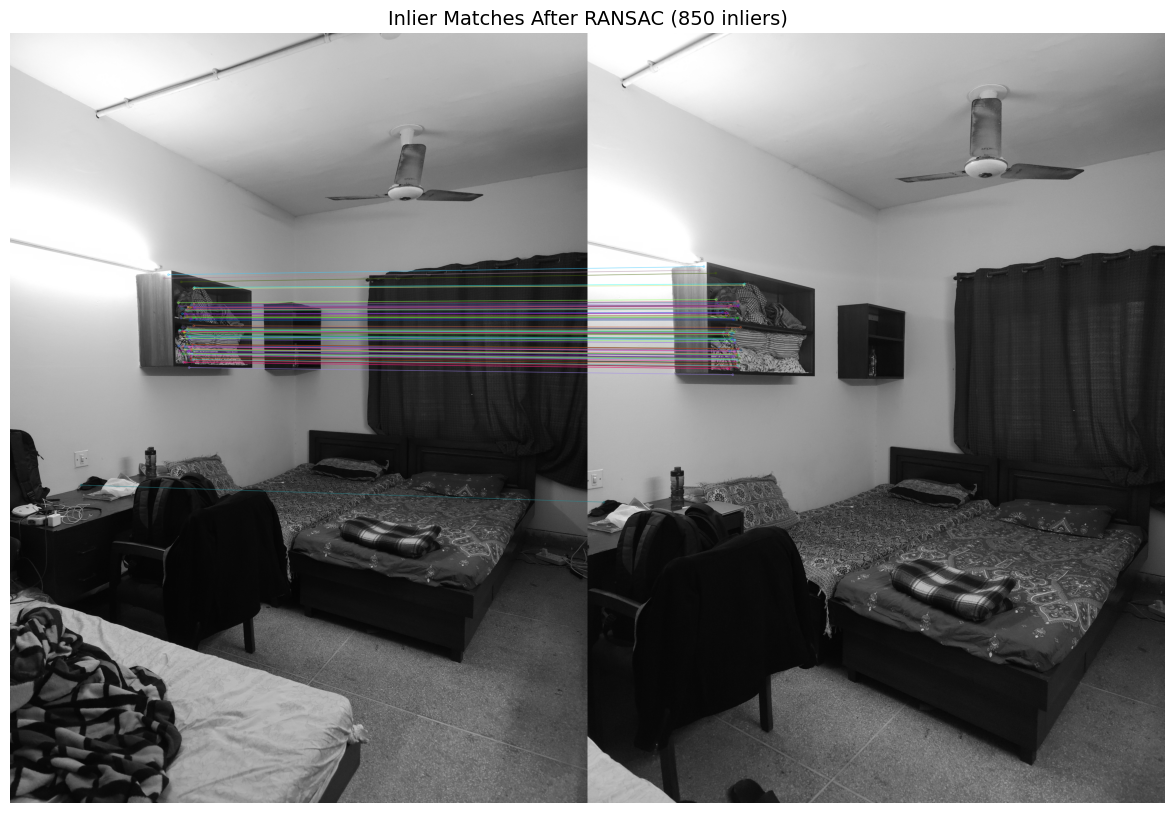

In [51]:

pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

print("\nEssential Matrix Estimation")
print(f"Using {len(pts1)} matched points")



E, mask_e = cv2.findEssentialMat(
    pts1, pts2, K, 
    method=cv2.RANSAC, 
    prob=0.999, 
    threshold=BEST_RANSAC  
)


inliers = mask_e.ravel() == 1
pts1_inliers = pts1[inliers]
pts2_inliers = pts2[inliers]
matches_inliers = [matches[i] for i in range(len(matches)) if inliers[i]]

print(E)
print(f"\nInliers after RANSAC: {np.sum(inliers)} / {len(pts1)}")
print(f"Inlier ratio: {np.sum(inliers)/len(pts1)*100:.2f}%")


img_inliers = cv2.drawMatches(
    img1_gray, kp1, img2_gray, kp2, matches_inliers[:100], None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(20, 10))
plt.imshow(img_inliers, cmap='gray')
plt.title(f'Inlier Matches After RANSAC ({len(matches_inliers)} inliers)', fontsize=14)
plt.axis('off')
plt.show()

## 3. Camera Pose Recovery



In [52]:



num_inliers, R, t, mask_pose = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)

print(f"\nRotation Matrix R:")
print(R)
print(f"\nTranslation Vector t:")
print(t.ravel())
print(f"\nNumber of points in front of both cameras: {num_inliers}")


det_R = np.linalg.det(R)
print(f"\nDeterminant of R (should be ~1): {det_R:.6f}")
print(f"R is orthogonal: {np.allclose(R @ R.T, np.eye(3))}")


Rotation Matrix R:
[[ 0.99657419 -0.04915272  0.06651229]
 [ 0.0469037   0.99828732  0.03496377]
 [-0.06811694 -0.03172432  0.99717283]]

Translation Vector t:
[-0.63673988  0.05485317 -0.76912513]

Number of points in front of both cameras: 849

Determinant of R (should be ~1): 1.000000
R is orthogonal: True


## 4. 3D Point Triangulation

Triangulate 3D points from two camera views.

In [53]:




P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))])


P2 = K @ np.hstack([R, t])

print("Projection Matrix P1 (Camera 1):")
print(P1)
print("\nProjection Matrix P2 (Camera 2):")
print(P2)


print(f"\nTriangulating {len(pts1_inliers)} points...")
points_4d_hom = cv2.triangulatePoints(P1, P2, pts1_inliers.T, pts2_inliers.T)


points_3d = points_4d_hom[:3] / points_4d_hom[3]
points_3d = points_3d.T  

print(f"Generated {len(points_3d)} 3D points")
print(f"\n3D points statistics:")
print(f"X range: [{points_3d[:, 0].min():.2f}, {points_3d[:, 0].max():.2f}]")
print(f"Y range: [{points_3d[:, 1].min():.2f}, {points_3d[:, 1].max():.2f}]")
print(f"Z range: [{points_3d[:, 2].min():.2f}, {points_3d[:, 2].max():.2f}]")

Projection Matrix P1 (Camera 1):
[[1.22666667e+03 0.00000000e+00 9.60000000e+02 0.00000000e+00]
 [0.00000000e+00 1.22666667e+03 1.28000000e+03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]

Projection Matrix P2 (Camera 2):
[[ 1.15707208e+03 -9.07493524e+01  1.03887433e+03 -1.51942770e+03]
 [-2.96544810e+01  1.18395865e+03  1.31927011e+03 -9.17193602e+02]
 [-6.81169445e-02 -3.17243188e-02  9.97172828e-01 -7.69125125e-01]]

Triangulating 850 points...
Generated 850 3D points

3D points statistics:
X range: [-3.07, 8.15]
Y range: [-2.70, 8.68]
Z range: [-1.49, 30.72]


In [54]:


valid_mask = filter_points(points_3d, pts1_inliers, pts2_inliers, R, t, K, max_reproj_error=BEST_REPROJ)  
points_3d_filtered = points_3d[valid_mask]

print(f"Valid points after filtering: {len(points_3d_filtered)} / {len(points_3d)}")
print(f"Filtered ratio: {len(points_3d_filtered)/len(points_3d)*100:.2f}%")

print(f"Filtered 3D points statistics:")
print(f"X range: [{points_3d_filtered[:, 0].min():.2f}, {points_3d_filtered[:, 0].max():.2f}]")
print(f"Y range: [{points_3d_filtered[:, 1].min():.2f}, {points_3d_filtered[:, 1].max():.2f}]")
print(f"Z range: [{points_3d_filtered[:, 2].min():.2f}, {points_3d_filtered[:, 2].max():.2f}]")

Valid points after filtering: 849 / 850
Filtered ratio: 99.88%
Filtered 3D points statistics:
X range: [-3.07, 8.15]
Y range: [-2.70, 8.68]
Z range: [3.55, 30.72]


## 6. Extract Point Colors

Get RGB colors for each 3D point from the original image.

In [55]:

colors = []
for i, is_valid in enumerate(valid_mask):
    if is_valid:
        x, y = pts1_inliers[i].astype(int)
        
        y = np.clip(y, 0, img1_color.shape[0] - 1)
        x = np.clip(x, 0, img1_color.shape[1] - 1)
        color = img1_color[y, x]
        colors.append(color)

colors = np.array(colors)
print(f"\nExtracted colors for {len(colors)} points")


Extracted colors for 849 points


## 7. Visualize 3D Point Cloud

Display the reconstructed point cloud with camera positions.

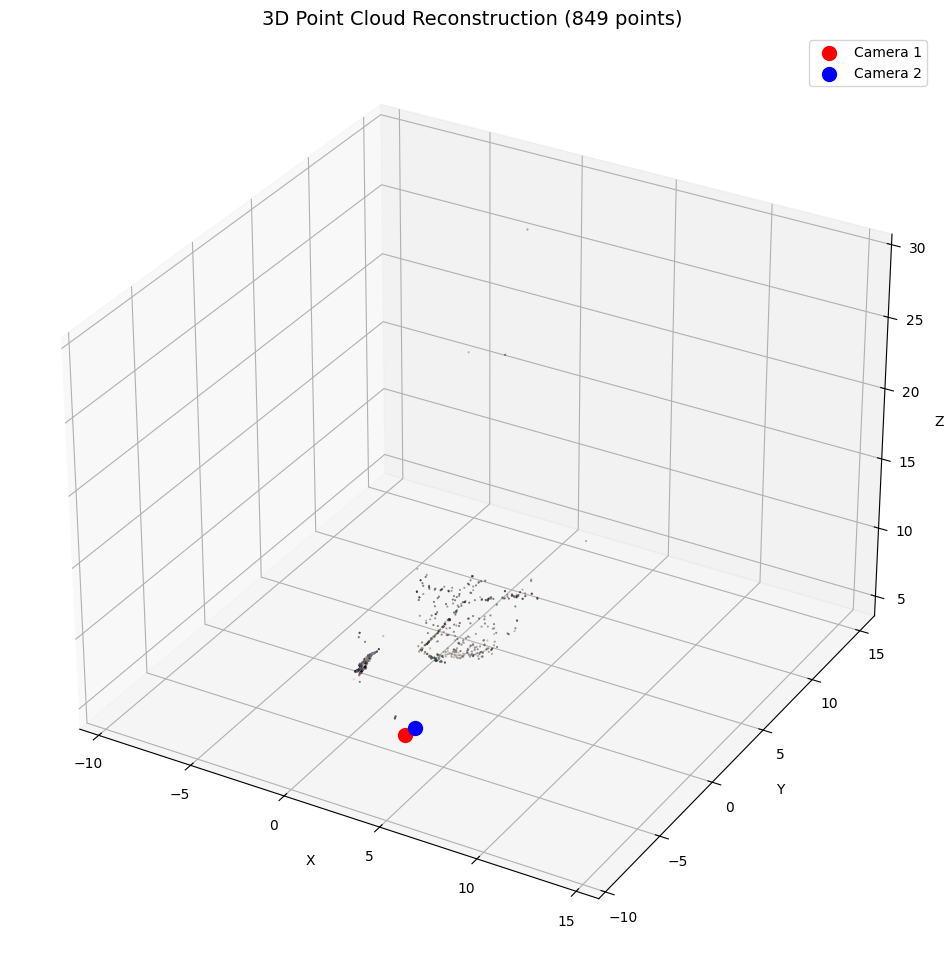

In [56]:


fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(
    points_3d_filtered[:, 0], 
    points_3d_filtered[:, 1], 
    points_3d_filtered[:, 2],
    c=colors/255.0,  
    marker='.',
    s=1,
    alpha=0.6
)


ax.scatter([0], [0], [0], c='red', marker='o', s=100, label='Camera 1')
cam2_pos = -R.T @ t
ax.scatter([cam2_pos[0]], [cam2_pos[1]], [cam2_pos[2]], 
           c='blue', marker='o', s=100, label='Camera 2')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'3D Point Cloud Reconstruction ({len(points_3d_filtered)} points)', fontsize=14)
ax.legend()


max_range = np.array([
    points_3d_filtered[:, 0].max() - points_3d_filtered[:, 0].min(),
    points_3d_filtered[:, 1].max() - points_3d_filtered[:, 1].min(),
    points_3d_filtered[:, 2].max() - points_3d_filtered[:, 2].min()
]).max() / 2.0

mid_x = (points_3d_filtered[:, 0].max() + points_3d_filtered[:, 0].min()) * 0.5
mid_y = (points_3d_filtered[:, 1].max() + points_3d_filtered[:, 1].min()) * 0.5
mid_z = (points_3d_filtered[:, 2].max() + points_3d_filtered[:, 2].min()) * 0.5

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()

## 8. Save Point Cloud as PLY File

Export the final 3D point cloud to PLY format.

In [57]:
def save_ply(filename, points, colors):
    """Save point cloud as PLY file"""
    with open(filename, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {len(points)}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")
        
        for i in range(len(points)):
            f.write(f"{points[i, 0]:.6f} {points[i, 1]:.6f} {points[i, 2]:.6f} ")
            f.write(f"{int(colors[i, 0])} {int(colors[i, 1])} {int(colors[i, 2])}\n")
    
    print(f"Saved {len(points)} points to {filename}")


save_ply('reconstruction.ply', points_3d_filtered, colors)
print(f"\nPoint cloud saved successfully!")

Saved 849 points to reconstruction.ply

Point cloud saved successfully!


In [58]:

import open3d as o3d

print("Visualizing reconstruction.ply...")
pcd = o3d.io.read_point_cloud("reconstruction.ply")
print(f"Points in reconstruction.ply: {len(pcd.points)}")
o3d.visualization.draw_geometries([pcd], window_name="Two-View Reconstruction")

Visualizing reconstruction.ply...
Points in reconstruction.ply: 849
[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.
